# Noisy generative processes (Chapter 2)

Creates the plot at the beginning of Chapter 2 showing how you can add noise to a linear function to generate points normally distributed across a line. 

==========================================================================

* **Notebook dependencies**:
    * See Notebook X for information on Jax
    * See Notebook Y for how to build environments

* **Content**: Jupyter notebook accompanying Chapter 2 of the textbook "Fundamentals of Active Inference"

* **Author**: Sanjeev Namjoshi (sanjeev.namjoshi@gmail.com)

* **Version**: 0.1

In [ ]:
# TODO: Change parameters to beta_0_star and beta_1_star
# TODO: Change external state to x_star

In [28]:
import jax
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import os
import sys

from jax.scipy.stats import norm
from jax import random
from types import SimpleNamespace

module_path = os.path.abspath(os.path.join(os.pardir, os.pardir))
if module_path not in sys.path:
    sys.path.append(module_path)
    
from src.env_base import Environment

mpl.style.use("seaborn-deep")

## Define the environment and helper functions

First, we use 49 different external states of the environment and use them to generate sensory data. The external states are mapped to sensory data using the generating function $y = 2x^*+3$ with added Gaussian noise. This generating function is captured in code as the function $y = \beta_1 x^* + \beta_0$, with $\beta_0 =3$ and $\beta_1=2$ which is specified by the function `ge()`. This naming is because in the book's mathematical notation we write $g_{\mathscr{E}}$ to specify the environment sensory mapping function.

In Jax, we specify the noise term with `loc + scale * jax.random.normal(key, (1,))` which samples from a zero-centered Gaussian with unit variance. To shift the mean and change the variance we can add the mean (`loc`) and multiple by the variance (`scale`). When this is added to the output of the data sample we obtain `y = ge(x) + noise`.

**Note**: 49 points are chosen because later we make use of the `np.median()` function and we want an odd number of points so we can select a single value for the median.

**Note**: The `SimpleNamespace(**params)` in the initialization converts the parameter dictionary into a namespace so that dictionary values can be easily accessed with the dot operator instead of the standard square bracket notation.

In [29]:
# Environment specification
class StaticEnvironment(Environment):
    def __init__(self, params: dict) -> None:
        self.params = SimpleNamespace(**params)
        
    def ge(self, x: float) -> float:
        return self.params.beta_1 * x + self.params.beta_0
    
    def noise(self, loc: float, scale: float, key: int) -> float:
        return loc + scale * jax.random.normal(key, (1,))
    
    def step(self, x: float, key: int) -> float:
        y = self.ge(x) + self.noise(loc=0, scale=self.params.var_y, key=key)
        return y

The helper function specifies the sensory mapping function and its inverse. These helper functions will be used later during plotting.

In [30]:
""" Helper functions """

# Generating function
def ge(x, beta_0, beta_1):
    y = beta_1 * x + beta_0
    return y

# Inverse generating function which can return the original state that generated the observation
def ge_inv(y, beta_0, beta_1):
    x = (y - beta_0) / beta_1
    return x

Now we set up the simulation. First, we need to specify the parameters for the environment. Here there are just three variables to consider: $\beta_0, \beta_1, \sigma^2_y$.

The simulation setup includes a random key, the support or range of values considered by $x^*$, and $n=49$ possible values of $x^*$ to randomly generate.

Finally, we initialize the sensory data array with zeros so it can be filled when the samples are generated.

In [31]:
# Environment parameters
params = {
    "beta_0": 3,   # Linear parameter intercept
    "beta_1": 2,   # Linear parameter slope
    "var_y" : 1,   # Likelihood variance
}

# Simulation setup
key     = jax.random.PRNGKey(549)                    # Jax random key
x_range = np.linspace(start=0.01, stop=5, num=500)   # Support of x
n       = 49                                         # Number of samples

# Initialize empty arrays 
y = np.zeros(n)

Here we generate the 49 external states, $x^*$. Then we initialize the `StaticEnvironment` class by passing in the parameter dictionary. 

Next, we loop across the different external states in the $x^*$ vector, create a random subkey for each one, and step through the environment each time to generate the sensory data.

**Note**: The `random.split()` function in Jax allows you to take a random seed key and split it into subkeys. This is needed because if we called `env.step()` 49 times with the same key, we would get the same noise each time. Instead, we want different noise for each sample, randomly sampled from the Gaussian that defines the noise.

In [32]:
# Generate 49 random external states
np.random.seed(4932)
x_star = np.random.choice(x_range, size=49)

# Initialize environment and generate data samples
env = StaticEnvironment(params=params)

for idx, x in enumerate(x_star):
    key, subkey = random.split(key)
    y[idx] = env.step(x, subkey)

## Generate data to plot

The code here is used to generate the Gaussian distribution that will appear in the plot.

In [33]:
# Generate the distribution around noise
point_x = np.median(x_star)                # x coordinate of a chosen sampled point
y_mean = ge(point_x, beta_0=3, beta_1=2)   # y coordinate at chosen sampled point
y_range = np.linspace(start=0.01, stop=12, num=500)
norm_cdf = norm.cdf(y_range, y_mean, params["var_y"])
norm_pdf = np.diff(norm_cdf) / (y_range[1] - y_range[0])   # PDF = derivative of CDF
norm_pdf[norm_pdf == 0] = np.nan
norm_pdf = np.append(norm_pdf, np.NaN)

# Inverse mapping of point_x
point_y = dict(zip(x_star, y))[np.median(x_star)]

## Plot the data points.

The plot is composed of multiple elements:
1. The samples from the noisy generative process. These are just the data points we generated with the `environment()` function.
2. The actual linear generating function (no noise). This is just the line $y= 2x+3$.
3. A normal distribution around a chosen sampled point. This uses the median function to pick a point in the middle of the plot (just so the plot is centered). Then a distribution is drawn around it to indicate that points sampled on the line here could fall in $\pm y$ range. To create the distribution we just create the CDF of the normal distribution at that point and then take the derivative to get the PDF.
4. Dotted "boundary lines" are added to show the $x$ and $y$ coordinates around the point on the line.
5. A red line is drawn to show how the noise has offset the point from the mean.

<Figure size 432x288 with 0 Axes>

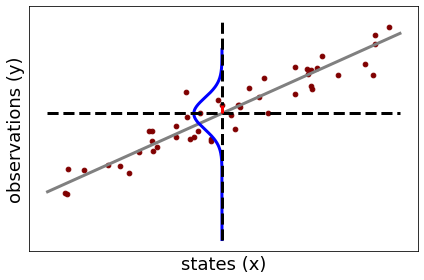

In [34]:
fig = plt.figure()
fig, ax = plt.subplots(1,1, facecolor=(1,1,1))

# Plot (1): Samples from probabilistic generative process
ax.scatter(x_star, y,
           s=22,
           c="maroon")

# Plot (2): Deterministic (linear) generating function
ax.plot(x_range.tolist(), [ge(elem, beta_0=3, beta_1=2) for elem in x_range],
        c="gray",
        linewidth=3)

# Plot (3): Normal distribution around the sampled point
ax.plot(-norm_pdf + ge_inv(y_mean, beta_0=3, beta_1=2), y_range,
        c="blue",
        linewidth=3)

# Plot (4): Boundary lines
ax.hlines(y=y_mean, xmin=0, xmax=5, 
          linestyle="dashed", 
          colors="black", 
          linewidth=3)

ax.vlines(x=ge_inv(y_mean, beta_0=3, beta_1=2), 
          ymin=0, ymax=14, 
          linestyle="dashed", 
          colors="black",
          linewidth=3)

# Plot (5): Error/offset for the samples point
ax.vlines(x=ge_inv(y_mean, beta_0=3, beta_1=2), 
          ymin=point_y, ymax=y_mean, 
          colors="red",
          linewidth=3)

# Axis labels and stylizing
ax.set_xlabel("states (x)", fontsize=18)
ax.set_ylabel("observations (y)", fontsize=18)
ax.tick_params(
    axis='both',          
    which='both',      
    bottom=False,      
    left=False,         
    labelbottom=False,
    labelleft=False)

fig.tight_layout()